在第一个人工智能程序中，使用对是单神经元神经网络，本次使用深度神经网络来提升预测精准度

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from testCases import *
from dnn_utils import *

%matplotlib inline 
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

# 工具函数编写

### 1.初始化参数

In [2]:
def initialize_parameters_deep(layer_dims):
    """
    功能 ：初始化参数w和b
    
    参数 ：
    layer_dims -- 每层神经元的个数
    
    返回值 ：
    parameters -- 包含每层对应的初始化好的w和b
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        #构建并随机初始化该层的W，根据《1.4.3 核对矩阵的维度》
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l-1])
        
        #构建并初始化b
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        #核对一下w和b的维度是我们预期的维度
        assert(parameters['W' + str(l)].shape == (layer_dims[l],layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l],1))
        
    #利用上面的循环，就可以为任意层数的神经网络进行参数初始化，只需要提供给每层神经元的个数
    return parameters

单元测试

In [3]:
parameters = initialize_parameters_deep([5,4,3])

In [4]:
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]
b2 = [[0.]
 [0.]
 [0.]]


### 2.前向传播

下面的linear_forward用于实现公式 $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$，这个称之为线性前向传播

In [5]:
def linear_forward(A, W, b):
    """
    功能 ：实现上面的公式
    
    参数 ： 
    A -- 本层的特征输入
    W -- 本层的相关w
    b -- 本层的相关b
    
    返回值 ：
    Z -- 根据公式计算出的本层的Z
    cache -- 由A， W， b组成的元组
    """
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b) # 将这些变量保存起来，因为后面进行反向传播时会用到它们
    
    return Z, cache

单元测试

In [6]:
A, W, b = linear_forward_test_case()
Z, linear_cache = linear_forward(A, W, b)

In [7]:
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


### 3.加激活后变为非线性前向传播

下面的linear_activation_forward用于实现公式 $A^{[l]} = g(Z^{[l]})$，g代表激活函数，使用了激活函数之后上面的线性前向传播就变成了非线性前向传播了。在dnn_utils.py中我们自定义了两个激活函数，sigmoid和relu。它们都会根据传入的Z计算出A。

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    功能 ：为前向传播加上激活函数
    
    参数 ：
    A_prev -- 上一层得到的A，输入到本层来计算Z和本层的A，第一层时为特征输入
    W -- 本层相关的W
    b -- 本层相关的b
    activation -- 在工具函数中定义有 “sigmoid”和“relu” 指示该层使用的激活函数
    
    返回值 ：
    A -- 激活后的A值
    cache -- 由linear_cache 和 Z 组成的元组
    """
    
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid": # 如果该层使用sigmoid        
        A = sigmoid(Z) 
    elif activation == "relu":
        A = relu(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, Z) # 缓存一些变量，后面的反向传播会用到它们

    return A, cache

单元测试

In [9]:
A_prev, W, b = linear_activation_forward_test_case()

In [10]:
A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]


In [11]:
A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With ReLU: A = [[3.43896131 0.        ]]


### 4.完整的前向传播

In [12]:
def L_model_forward(X, parameters):
    """
    功能 ：完整的前向传播过程，前L-1层使用relu，最后一层使用sigmoid
    
    参数 ：
    X -- 输入的特征数据
    parameters -- 由w和b组成的list，含有每一层的w和b
    
    返回值 ：
    AL -- 即预测值y‘
    cache -- 由A， W， b， Z 组成的元组，保存这些值在反向传播中使用
    """
    
    caches = []
    A = X
    
    # 获取参数列表的长度，这个长度的一半就是神经网络的层数。
    # 为什么是一半呢？因为列表是这样的[w1,b1,w2,b2...wl,bl],里面的w1和b1代表了一层
    L = len(parameters) // 2  
    
    # 循环L-1次，即进行L-1步前向传播，每一步使用的激活函数都是relu
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)],
                                             activation='relu')
        caches.append(cache)# 把一些变量数据保存起来，以便后面的反向传播使用
        
    
    # 进行最后一层的前向传播，这一层的激活函数是sigmoid。得出的AL就是y'预测值
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
   
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

单元测试

In [13]:
X, parameters = L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)

In [14]:
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.17007265 0.2524272 ]]
Length of caches list = 2


### 5.计算成本

In [15]:
def compute_cost(AL, Y):
    """
    功能 ： 计算成本
    
    参数 ：
    AL -- 即预测值y‘
    Y -- 特征数据对应的标签数据
    
    返回值：
    cost -- 成本
    """
    
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1 - Y),np.log(1 - AL)))
    
    #确保cost是一个值，而不是一个数组的形式
    cost = np.squeeze(cost)
    
    assert(cost.shape == ())
    
    return cost

单元测试

In [16]:
Y, AL = compute_cost_test_case()
print("cost = " + str(compute_cost(AL, Y)))

cost = 0.41493159961539694


下面的linear_backward函数用于根据后一层的dZ来计算前面一层的dW，db和dA。也就是实现了下面3个公式
$$ dW^{[l]}  = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]}  = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = W^{[l] T} dZ^{[l]}$$

### 6.反向传播

In [17]:
def linear_backward(dZ, cache):
    """
    功能 ： 实现上面的三个公式，根据后一层的dZ来计算前面一层的dW，db，dA
    
    参数 ：
    dZ -- 后面一层的dz
    cache -- 前向传播保存的 由A， W， b， Z 组成的元组
    
    返回值 ：
    dA_prev -- 前一层的dA
    dW -- 前一层的dW
    db -- 前一层的db
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

单元测试

In [18]:
dZ, linear_cache = linear_backward_test_case()
dA_prev, dW, db = linear_backward(dZ, linear_cache)

In [19]:
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


### 7.加激活后的反向传播

下面的linear_activation_backward用于根据本层的dA计算出本层的dZ。就是实现了下面的公式
$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$
上式的g'()表示求Z相当于本层的激活函数的偏导数。所以不同的激活函数也有不同的求导公式。
我们为大家编写了两个求导函数sigmoid_backward和relu_backward。大家当前不需要关心这两个函数的内部实现，当然，如果你感兴趣可以到dnn_utils.py里面去看它们的实现。

In [20]:
def linear_activation_backward(dA, cache, activation):
    """
    功能 ：加上激活函数的反向传播
    
    参数 ： 
    dA -- 本层的dA
    cache -- 前向传播保存的 由A， W， b， Z 组成的元组
    activation -- 指示该层使用的是什么激活函数: "sigmoid" 或 "relu"
    
    返回值 ：
    前一层的dA
    dW -- 前一层的dW
    db -- 前一层的db
    """
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    # 这里我们又顺带根据本层的dZ算出本层的dW和db以及前一层的dA
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

单元测试1 -- sigmoid

In [21]:
dAL, linear_activation_cache = linear_activation_backward_test_case()
dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]



单元测试2 -- relu

In [22]:
dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

relu:
dA_prev = [[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


### 8.完整的反向传播

In [23]:
def L_model_backward(AL, Y, caches):
    """
    功能 ：构建出一个完整的反向传播
    
    参数 ：
    AL -- 即预测值y‘
    Y -- 真实标签
    cache -- 前向传播保存的 由A， W， b， Z 组成的元组
    
    返回值 ：
    grads -- 由dA，dW，db组成的字典
    """
    
    grads = {}
    L = len(caches) # 获取神经网络层数。caches列表的长度就等于神经网络的层数
    Y = Y.reshape(AL.shape) # 让真实标签的维度和预测标签的维度一致
    
    # 计算出最后一层的dA，前面文章我们以及解释过，最后一层的dA与前面各层的dA的计算公式不同，
    # 因为最后一个A是直接作为参数传递到成本函数的，所以不需要链式法则而直接就可以求dA（A相当于成本函数的偏导数）
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # 计算最后一层的dW和db，因为最后一层使用的激活函数是sigmoid
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
                                                                                            dAL, 
                                                                                            current_cache,
                                                                                            activation = "sigmoid")

    # 计算前面L-1层到第一层的每层的梯度，这些层都使用relu激活函数
    for c in reversed(range(1,L)): # reversed(range(1,L))的结果是L-1,L-2...1。是不包括L的。第0层是输入层，不必计算。
        # 这里的c表示当前层
        grads["dA" + str(c-1)], grads["dW" + str(c)], grads["db" + str(c)] = linear_activation_backward(
            grads["dA" + str(c)], 
            caches[c-1],
            # 这里我们也是需要当前层的caches，但是为什么是c-1呢？因为grads是字典，我们从1开始计数，而caches是列表，
            # 是从0开始计数。所以c-1就代表了c层的caches。数组的索引很容易引起莫名其妙的问题，大家编程时一定要留意。
            activation = "relu")

    return grads

单元测试

In [24]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


下面的update_parameters函数将利用这些梯度来更新/优化每一层的w和b，也就是进行梯度下降。
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$

In [25]:
def update_parameters(parameters, grads, learning_rate):
    """
    功能 ：更新参数w和b
    
    参数 ：
    parameters -- 每一层的参数w和b
    grads -- 每一层的梯度
    learning_rate -- 学习率
    
    返回值 ：
    parameters -- 由w和b组成的字典
    """
    
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        parameters['W' + str(l)] = parameters['W' + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - learning_rate * grads['db' + str(l)]
        
    return parameters    

单元测试

In [26]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = " + str(parameters["W1"]))
print ("b1 = " + str(parameters["b1"]))
print ("W2 = " + str(parameters["W2"]))
print ("b2 = " + str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


至此，工具函数都编写好了
构建一个深度神经网络以识别图片中是否有猫

# 1.加载数据集

In [27]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

m_train = train_x_orig.shape[0] # 训练样本的数量
m_test = test_x_orig.shape[0] # 测试样本的数量
num_px = test_x_orig.shape[1] # 每张图片的宽/高

# 为了方便后面进行矩阵运算，我们需要将样本数据进行扁平化和转置
# 处理后的数组各维度的含义是（图片数据，样本数）
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T 

# 下面我们对特征数据进行了简单的标准化处理（除以255，使所有值都在[0，1]范围内）
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

# 2.构建深度神经网络

In [28]:
def dnn_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000,print_cost=False):
    """
    功能 ：构建深度神经网络完成识别猫的dnn
    
    参数 ：
    X -- 特征数据
    Y -- 特征数据对应的标签
    layers_dims -- 每层神经元的个数
    learning_rate -- 学习率
    num_iterations -- 训练多少次
    print_cost -- 是否打印cost
    
    返回值 ：
    parameters -- 返回训练好的w和b，用来识别新的图片
    """
    
    np.random.seed(1)
    costs = []                  

    # 初始化每层的参数w和b
    parameters = initialize_parameters_deep(layers_dims)
    
    # 按照指示的次数来训练深度神经网络
    for i in range(0, num_iterations):
        # 进行前向传播
        AL, caches = L_model_forward(X, parameters)
        # 计算成本
        cost = compute_cost(AL, Y)
        # 进行反向传播
        grads = L_model_backward(AL, Y, caches)
        # 更新参数，好用这些参数进行下一轮的前向传播
        parameters = update_parameters(parameters, grads, learning_rate)

        # 打印出成本
        if i % 100 == 0:
            if print_cost and i > 0:
                print ("训练%i次后成本是: %f" % (i, cost))
            costs.append(cost)
            
    # 画出成本曲线图
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [29]:
#4层的神经网络，12288是输入层
#第一层有20个神经元，第二层有7个神经元
layers_dims = [12288, 20, 7, 5, 1]

训练100次后成本是: 0.672053
训练200次后成本是: 0.648263
训练300次后成本是: 0.611507
训练400次后成本是: 0.567047
训练500次后成本是: 0.540138
训练600次后成本是: 0.527930
训练700次后成本是: 0.465477
训练800次后成本是: 0.369126
训练900次后成本是: 0.391747
训练1000次后成本是: 0.315187
训练1100次后成本是: 0.272700
训练1200次后成本是: 0.237419
训练1300次后成本是: 0.199601
训练1400次后成本是: 0.189263
训练1500次后成本是: 0.161189
训练1600次后成本是: 0.148214
训练1700次后成本是: 0.137775
训练1800次后成本是: 0.129740
训练1900次后成本是: 0.121225


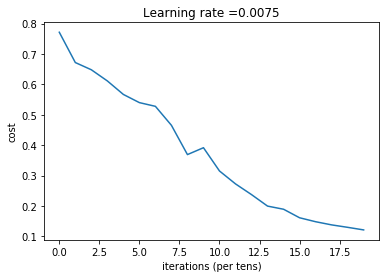

In [30]:
# 设置好深度神经网络的层次信息——下面代表了一个4层的神经网络（12288是输入层），
# 第一层有20个神经元，第二层有7个神经元。。。
# 你也可以构建任意层任意神经元数量的神经网络，只需要更改下面这个数组就可以了
layers_dims = [12288, 20, 7, 5, 1]

# 根据上面的层次信息来构建一个深度神经网络，并且用之前加载的数据集来训练这个神经网络，得出训练后的参数
parameters = dnn_model(train_x, train_y, layers_dims, num_iterations=2000, print_cost=True)

# 3.预测

In [31]:
def predict(X,parameters):   
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # 进行一次前向传播，得到预测结果
    probas, caches = L_model_forward(X, parameters)
   
    # 将预测结果转化成0和1的形式，即大于0.5的就是1，否则就是0
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
        
    return p

In [32]:
# 对训练数据集进行预测
pred_train = predict(train_x,parameters)
print("预测准确率是: "  + str(np.sum((pred_train == train_y) / train_x.shape[1])))

预测准确率是: 0.9808612440191385


In [33]:
# 对测试数据集进行预测
pred_test = predict(test_x,parameters)
print("预测准确率是: "  + str(np.sum((pred_test == test_y) / test_x.shape[1])))

预测准确率是: 0.8


学习率为 ： 0.01时
训练100次后成本是: 0.669270
训练200次后成本是: 0.638874
训练300次后成本是: 0.597884
训练400次后成本是: 0.568827
训练500次后成本是: 0.461260
训练600次后成本是: 0.508484
训练700次后成本是: 0.327596
训练800次后成本是: 0.310398
训练900次后成本是: 0.248831
训练1000次后成本是: 0.207309
训练1100次后成本是: 0.140485
训练1200次后成本是: 0.115670
训练1300次后成本是: 0.099260
训练1400次后成本是: 0.085845
训练1500次后成本是: 0.074975
训练1600次后成本是: 0.067809
训练1700次后成本是: 0.058402
训练1800次后成本是: 0.052054
训练1900次后成本是: 0.047680


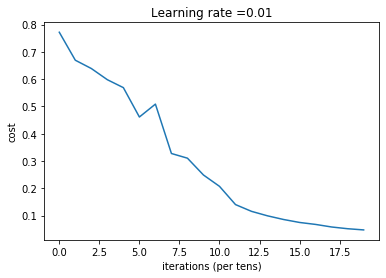


-------------------------------------------------------

学习率为 ： 0.001时
训练100次后成本是: 0.689995
训练200次后成本是: 0.686078
训练300次后成本是: 0.682513
训练400次后成本是: 0.678903
训练500次后成本是: 0.675207
训练600次后成本是: 0.671589
训练700次后成本是: 0.667515
训练800次后成本是: 0.663322
训练900次后成本是: 0.658617
训练1000次后成本是: 0.653823
训练1100次后成本是: 0.649142
训练1200次后成本是: 0.644045
训练1300次后成本是: 0.639066
训练1400次后成本是: 0.634042
训练1500次后成本是: 0.628573
训练1600次后成本是: 0.623221
训练1700次后成本是: 0.617792
训练1800次后成本是: 0.612347
训练1900次后成本是: 0.606662


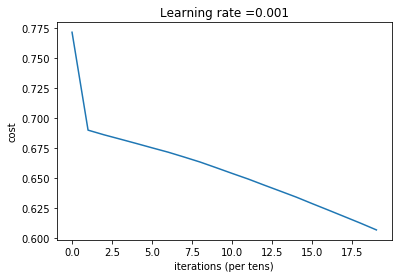


-------------------------------------------------------

学习率为 ： 0.0001时
训练100次后成本是: 0.698481
训练200次后成本是: 0.695327
训练300次后成本是: 0.694214
训练400次后成本是: 0.693274
训练500次后成本是: 0.692545
训练600次后成本是: 0.691932
训练700次后成本是: 0.691385
训练800次后成本是: 0.690871
训练900次后成本是: 0.690413
训练1000次后成本是: 0.689993
训练1100次后成本是: 0.689593
训练1200次后成本是: 0.689222
训练1300次后成本是: 0.688859
训练1400次后成本是: 0.688496
训练1500次后成本是: 0.688132
训练1600次后成本是: 0.687767
训练1700次后成本是: 0.687380
训练1800次后成本是: 0.686983
训练1900次后成本是: 0.686583


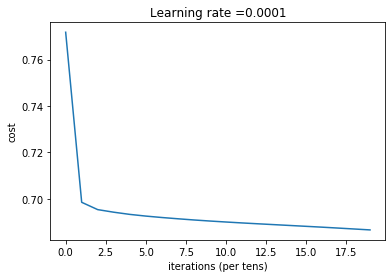


-------------------------------------------------------



KeyError: 'costs'

In [34]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print('学习率为 ： '  + str(i) + '时')
    #models 就是return的d
    models[str(i)] = dnn_model(train_x, train_y, layers_dims, learning_rate=i, num_iterations=2000, print_cost=True)
    print ('\n' + "-------------------------------------------------------" + '\n')
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]['costs']),label = str(models[str(i)]['learning_rate']))

plt.ylabel('cost')
plt.xlabel('iterations (hundres)')

#图例
legend = plt.legend(loc = 'upper center', shadow = True)

plt.show()